# Importing libraries

In [71]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt


# Loading the data

In [72]:
directory_path = '/fsx1/emory-mammo/tables/'

file_names = {
    'cancer_hist': 'CancerHist_anon.csv',
    'full_magview': 'full_magview.csv',
    'risk_hist': 'RiskHist_anon.csv',
    'hormone_hist': 'HormoneHist_anon.csv',
    'procedure_hist': 'ProcedureHist_anon.csv',
    'filtered_magview_reduced': 'filtered_magview_reduced.csv',
    'filtered_metadata_reduced': 'filtered_metadata_reduced.csv'
}

cancer_hist_df = pd.read_csv(directory_path + file_names['cancer_hist'])
full_magview_df = pd.read_csv(directory_path + file_names['full_magview'])
risk_hist_df = pd.read_csv(directory_path + file_names['risk_hist'])
hormone_hist_df = pd.read_csv(directory_path + file_names['hormone_hist'])
procedure_hist_df = pd.read_csv(directory_path + file_names['procedure_hist'])
filtered_magview_reduced_df = pd.read_csv(directory_path + file_names['filtered_magview_reduced'])
filtered_metadata_reduced_df = pd.read_csv(directory_path + file_names['filtered_metadata_reduced'])



/tmp/ipykernel_37977/3580893392.py:14: DtypeWarning: Columns (31,34,36,51,52,53,54,56,57,58,59,60,62,64,66,79,81,84,85,87,88,96,114) have mixed types. Specify dtype option on import or set low_memory=False.
  full_magview_df = pd.read_csv(directory_path + file_names['full_magview'])
/tmp/ipykernel_37977/3580893392.py:15: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  risk_hist_df = pd.read_csv(directory_path + file_names['risk_hist'])
/tmp/ipykernel_37977/3580893392.py:18: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  filtered_magview_reduced_df = pd.read_csv(directory_path + file_names['filtered_magview_reduced'])
/tmp/ipykernel_37977/3580893392.py:19: DtypeWarning: Columns (26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  filtered_metadata_reduced_df = pd.read_csv(directory_path + file_names['filtered_metadata_reduced'])


In [73]:
risk_hist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230350 entries, 0 to 230349
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   tissueden  229014 non-null  object 
 1   ftissue    229014 non-null  object 
 2   NCILIFE    230350 non-null  float64
 3   IBISLIFE   230350 non-null  float64
 4   IBISBRCA1  230350 non-null  float64
 5   IBISBRCA2  230350 non-null  float64
 6   IBIS10     230350 non-null  float64
 7   IBISPOP10  230350 non-null  float64
 8   IBISPOPL   230350 non-null  float64
 9   NCI5       230350 non-null  float64
 10  IBIS_TD1   230350 non-null  float64
 11  IBIS_TD2   230350 non-null  float64
 12  IBIS_TD3   230350 non-null  float64
 13  IBIS_TD4   230350 non-null  float64
 14  empi_anon  230350 non-null  int64  
 15  acc_anon   230350 non-null  int64  
dtypes: float64(12), int64(2), object(2)
memory usage: 28.1+ MB


# Looking at the Spearman Correlation between Risk Factors and Path Severity

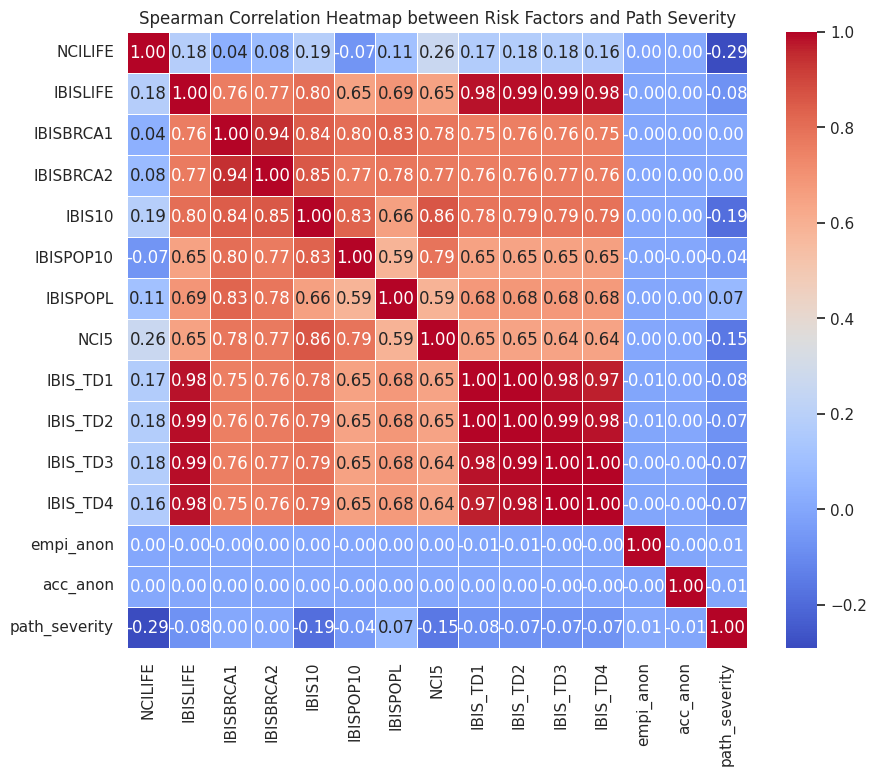

In [74]:

# Select only numeric columns from risk_hist_df
numeric_df = risk_hist_df.select_dtypes(include=['number'])

# Merge the numeric risk history data with path_severity from filtered_magview_reduced_df
combined_df = pd.merge(numeric_df, full_magview_df[['empi_anon', 'path_severity']], on='empi_anon')

# Calculate the Spearman correlation matrix
corr_matrix = combined_df.corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Spearman Correlation Heatmap between Risk Factors and Path Severity')
plt.show()


# Preprocessing and combining path_severity and risk hist

In [49]:
filtered_magview_reduced_df.path_severity = filtered_magview_reduced_df.path_severity.fillna(100)

In [50]:
filtered_magview_reduced_df_pth_svrty = filtered_magview_reduced_df[['empi_anon', 'acc_anon', 'path_severity']].groupby(['empi_anon', 'acc_anon'])['path_severity'].min().reset_index()

In [51]:
filtered_magview_reduced_df_pth_svrty = filtered_magview_reduced_df_pth_svrty.replace(100, np.nan)

In [52]:
risk_hist_df[['IBISLIFE', 'NCILIFE']]

,IBISLIFE,NCILIFE
0,7.6,5.4
1,20.8,12.5
2,11.1,3.3
3,0.0,17.3
4,9.5,8.8
...,...,...
230345,9.8,6.9
230346,6.2,4.0
230347,6.4,5.1
230348,22.4,17.0


In [53]:
filtered_magview_reduced_df_pth_svrty.shape

(90497, 3)

In [54]:
filtered_magview_reduced_df_pth_svrty_rsc = filtered_magview_reduced_df_pth_svrty.merge(risk_hist_df, on = ['empi_anon', 'acc_anon'])

In [55]:
rsk_cols = ['NCILIFE', 'IBISLIFE', 'IBISBRCA1', 'IBISBRCA2', 'IBIS10', 'IBISPOP10',
       'IBISPOPL', 'NCI5', 'IBIS_TD1', 'IBIS_TD2', 'IBIS_TD3', 'IBIS_TD4']

# Calculating AUC on Path Severity Grouped and Risk Scores

In [57]:
# Function to calculate AUC
def calculate_auc(y_true, y_scores):
    return roc_auc_score(y_true, y_scores)

# Define the conversion rules
conditions = [
    {'condition': lambda labels: (labels == 0).astype(int), 'name': 'labels 0'},
    {'condition': lambda labels: (labels.isin([0, 1])).astype(int), 'name': 'labels 0,1'},
    {'condition': lambda labels: (labels.isin([0, 1, 2])).astype(int), 'name': 'labels 0,1,2'},
    {'condition': lambda labels: (labels.isin([0, 1, 2, 3])).astype(int), 'name': 'labels 0,1,2,3'},
    {'condition': lambda labels: (labels.isin([0, 1, 2, 3, 4])).astype(int), 'name': 'labels 0,1,2,3,4'}
]

results = []

# Loop through each condition and prediction column
for cond in conditions:
    # Apply condition to create binary column
    binary_col_name = f'binary_{cond["name"]}'
    filtered_magview_reduced_df_pth_svrty_rsc[binary_col_name] = cond['condition'](filtered_magview_reduced_df_pth_svrty_rsc['path_severity'])
    
    # Print current condition being evaluated
    print(f'\nEvaluating condition: {cond["name"]}')
    
    for pred_col in rsk_cols:
        # Calculate AUC for each prediction column
        auc = calculate_auc(filtered_magview_reduced_df_pth_svrty_rsc[binary_col_name], filtered_magview_reduced_df_pth_svrty_rsc[pred_col])
        
        # Print AUC result
        # print(f'AUC for {pred_col} with condition {cond["name"]}: {auc:.4f}')
        
        # Append result to the list
        results.append({
            'Condition': cond["name"],
            'Prediction Column': pred_col,
            'AUC': auc
        })
# Convert results to DataFrame
results_df = pd.DataFrame(results)



Evaluating condition: labels 0

Evaluating condition: labels 0,1

Evaluating condition: labels 0,1,2

Evaluating condition: labels 0,1,2,3

Evaluating condition: labels 0,1,2,3,4


In [60]:
results_df.sort_values(['Prediction Column', 'Condition'])

,Condition,Prediction Column,AUC
4,labels 0,IBIS10,0.531751
16,"labels 0,1",IBIS10,0.540738
28,"labels 0,1,2",IBIS10,0.523841
40,"labels 0,1,2,3",IBIS10,0.522944
52,"labels 0,1,2,3,4",IBIS10,0.507403
2,labels 0,IBISBRCA1,0.508348
14,"labels 0,1",IBISBRCA1,0.519275
26,"labels 0,1,2",IBISBRCA1,0.517946
38,"labels 0,1,2,3",IBISBRCA1,0.519061
50,"labels 0,1,2,3,4",IBISBRCA1,0.523955


In [59]:
filtered_magview_reduced_df_pth_svrty_rsc

,empi_anon,acc_anon,path_severity,tissueden,ftissue,NCILIFE,IBISLIFE,IBISBRCA1,IBISBRCA2,IBIS10,...,NCI5,IBIS_TD1,IBIS_TD2,IBIS_TD3,IBIS_TD4,binary_labels 0,"binary_labels 0,1","binary_labels 0,1,2","binary_labels 0,1,2,3","binary_labels 0,1,2,3,4"
0,10000879,6992096043050201,NaN,3,3,7.4,11.2,0.1,0.1,1.5,...,0.5,11.2,11.2,11.2,11.2,0,0,0,0,0
1,10000879,8162137067574239,NaN,3,3,7.3,11.4,0.1,0.1,1.9,...,0.6,5.0,7.6,11.4,16.8,0,0,0,0,0
2,10003315,2398666806671189,2.0,3,3,9.8,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,1,1,1
3,10015693,2281263876413228,NaN,2,2,7.9,8.4,0.1,0.1,4.4,...,2.3,8.4,8.4,8.4,8.4,0,0,0,0,0
4,10019048,8545300395264346,NaN,4,4,15.8,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54099,99986224,8848125344172315,NaN,1,1,35.1,15.1,0.4,0.6,15.1,...,22.0,15.1,15.1,15.1,15.1,0,0,0,0,0
54100,99996622,9655172659462321,NaN,3,3,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
54101,99999564,4369225803558884,NaN,3,3,7.7,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
54102,99999564,8832872399780580,NaN,3,3,6.8,3.4,0.1,0.1,3.4,...,3.2,3.4,3.4,3.4,3.4,0,0,0,0,0


In [61]:
filtered_magview_reduced_df_pth_svrty_rsc.columns

Index(['empi_anon', 'acc_anon', 'path_severity', 'tissueden', 'ftissue',
       'NCILIFE', 'IBISLIFE', 'IBISBRCA1', 'IBISBRCA2', 'IBIS10', 'IBISPOP10',
       'IBISPOPL', 'NCI5', 'IBIS_TD1', 'IBIS_TD2', 'IBIS_TD3', 'IBIS_TD4',
       'binary_labels 0', 'binary_labels 0,1', 'binary_labels 0,1,2',
       'binary_labels 0,1,2,3', 'binary_labels 0,1,2,3,4'],
      dtype='object')

In [69]:
def bucket_nci5(score):
    if score <= 5:
        return 'Low'
    elif score <= 10:
        return 'Medium'
    else:
        return 'High'

# Apply the function to the NCI5 scores column
filtered_magview_reduced_df_pth_svrty_rsc['NCI5_Risk_Bucket'] = filtered_magview_reduced_df_pth_svrty_rsc['NCI5'].apply(bucket_nci5)



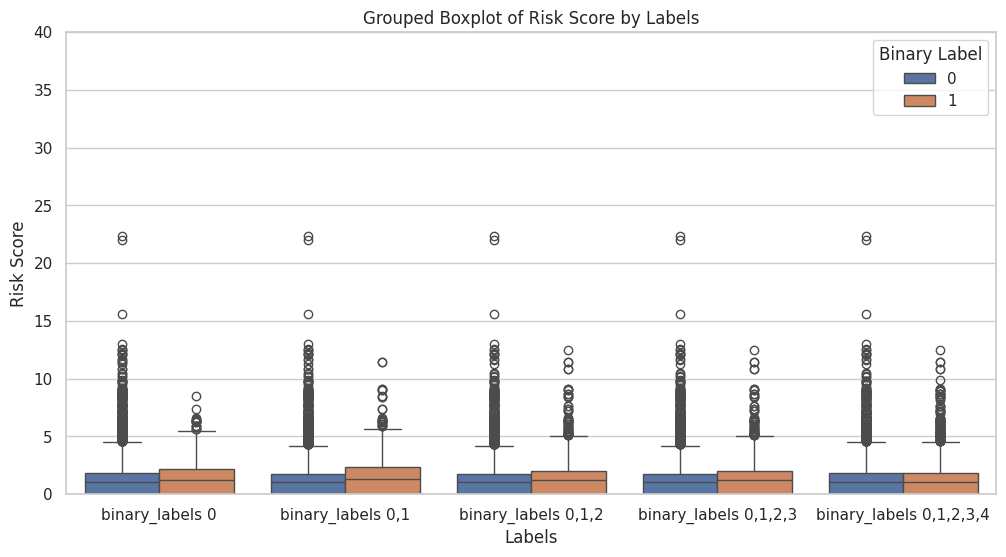

In [70]:
# Melt the DataFrame to a long format
df_melted = filtered_magview_reduced_df_pth_svrty_rsc.melt(id_vars=['empi_anon', 'acc_anon', 'NCI5'], 
                    value_vars=['binary_labels 0', 'binary_labels 0,1', 'binary_labels 0,1,2',
       'binary_labels 0,1,2,3', 'binary_labels 0,1,2,3,4'], 
                    var_name='Label', 
                    value_name='Binary')
# Create the grouped boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Label', y='NCI5', hue='Binary', data=df_melted)
plt.title('Grouped Boxplot of Risk Score by Labels')
plt.xlabel('Labels')
plt.ylabel('Risk Score')
plt.ylim(0, 40)
plt.legend(title='Binary Label')
plt.show()
